In [119]:
import json
import os
import glob
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



class ExperimentLoader:
    def __init__(self, experiment_path):
        self.experiment_path = experiment_path
        self.config = None
        self.run_folders = []
        self.run_data_cache = {}

        self._load_config()
        self._find_run_folders()
        self._load_all_run_data()

    def _load_config(self):
        config_path = os.path.join(self.experiment_path, 'experiment.json')
        if not os.path.isfile(config_path):
            # Try finding any .json file if experiment.json doesn't exist
            json_files = glob.glob(os.path.join(
                self.experiment_path, '*.json'))
            if not json_files:
                print(
                    f"Warning: No JSON configuration file found in {self.experiment_path}")
                return  # Or raise an error if config is mandatory
            config_path = json_files[0]  # Load the first one found
            print(
                f"Warning: 'experiment.json' not found. Loading {os.path.basename(config_path)} instead.")

        try:
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        except json.JSONDecodeError as e:
            raise ValueError(f"Error decoding JSON from {config_path}: {e}")
        except Exception as e:
            raise IOError(f"Error reading file {config_path}: {e}")

    def _find_run_folders(self):
        potential_runs = glob.glob(os.path.join(self.experiment_path, 'run_*'))
        self.run_folders = [
            run for run in potential_runs if os.path.isdir(run)]
        self.run_folders.sort()  # Sort them for consistency

    def _load_run_data(self, run_folder):
        if run_folder in self.run_data_cache:
            return self.run_data_cache[run_folder]

        file_path = os.path.join(run_folder, "run.json")
        if not os.path.exists(file_path):
            print(f"Warning: File not found {file_path}")
            self.run_data_cache[run_folder] = None
            return None
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                self.run_data_cache[run_folder] = data
                return data
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            self.run_data_cache[run_folder] = None
            return None

    def _load_all_run_data(self):
        for run_folder in self.run_folders:
            self._load_run_data(run_folder)  # Load and cache

    def get_all_best_rewards(self):
        all_best_rewards = []
        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                history = data.get("best_reward_history")
                if history and isinstance(history, list) and len(history) > 0:
                    # all_best_rewards.append(float(history[-1])) # Last element is the final best
                    all_best_rewards.append(max(history))

                else:
                    print(
                        f"Warning: 'best_reward_history' missing, empty, or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        return all_best_rewards

    def avg_best_reward_with_std(self):
        all_best_rewards = self.get_all_best_rewards()

        if not all_best_rewards:
            return np.nan, np.nan

        avg_reward = np.mean(all_best_rewards)
        # Use sample standard deviation (ddof=1)
        std_reward = np.std(all_best_rewards, ddof=1)
        return avg_reward, std_reward

    def get_all_best_fitness(self):
        all_best_fitness = []
        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                fitness = data.get("best_fitness")
                if fitness is not None:
                    all_best_fitness.append(float(fitness))
                else:
                    print(
                        f"Warning: 'best_fitness' missing or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        return all_best_fitness

    def avg_best_fitness_with_std(self):
        all_best_fitness = self.get_all_best_fitness()

        if not all_best_fitness:
            return np.nan, np.nan

        avg_fitness = np.mean(all_best_fitness)
        # Use sample standard deviation (ddof=1)
        std_fitness = np.std(all_best_fitness, ddof=1)
        return avg_fitness, std_fitness

    def avg_best_fitness_per_generation_with_std(self):

        all_runs_fitness_logs = []
        min_generations = float('inf')

        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                # Use best_fitness_history
                log_data = data.get("best_fitness_history")
                if log_data is not None and isinstance(log_data, list) and len(log_data) > 0:
                    all_runs_fitness_logs.append(np.array(log_data))
                    min_generations = min(min_generations, len(log_data))
                else:
                    print(
                        f"Warning: 'best_fitness_history' missing, empty or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        if not all_runs_fitness_logs or min_generations == float('inf'):
            return np.array([]), np.array([])

        # Trim logs to the minimum length found across runs
        trimmed_logs = [log[:min_generations] for log in all_runs_fitness_logs]

        # Stack logs into a 2D array (runs x generations)
        fitness_matrix = np.stack(trimmed_logs, axis=0)

        # Calculate mean and std dev across runs (axis=0) for each generation
        avg_fitness_per_gen = np.mean(fitness_matrix, axis=0)
        # Use sample standard deviation (ddof=1)
        std_fitness_per_gen = np.std(fitness_matrix, axis=0, ddof=1)

        return avg_fitness_per_gen, std_fitness_per_gen

    def avg_best_reward_per_generation_with_std(self):
        """
        Calculates the average and std dev of the best reward
        for each generation across all runs, using 'best_reward_history'.
        """
        all_runs_reward_logs = []
        min_generations = float('inf')

        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                # Use best_reward_history
                log_data = data.get("best_reward_history")
                if log_data is not None and isinstance(log_data, list) and len(log_data) > 0:
                    all_runs_reward_logs.append(np.array(log_data))
                    min_generations = min(min_generations, len(log_data))
                else:
                    print(
                        f"Warning: 'best_reward_history' missing, empty or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        if not all_runs_reward_logs or min_generations == float('inf'):
            return np.array([]), np.array([])

        # Trim logs
        trimmed_logs = [log[:min_generations] for log in all_runs_reward_logs]

        # Stack logs into a 2D array (runs x generations)
        reward_matrix = np.stack(trimmed_logs, axis=0)

        # Calculate mean and std dev across runs (axis=0) for each generation
        avg_reward_per_gen = np.mean(reward_matrix, axis=0)
        # Use sample standard deviation (ddof=1)
        std_reward_per_gen = np.std(reward_matrix, axis=0, ddof=1)

        return avg_reward_per_gen, std_reward_per_gen

In [149]:
def plot_rewards_and_boxplot_with_avg(algorithms, labels):
    """
    Combine the reward plot and box plot into the same figure.
    Also calculates and displays the average of average rewards for each algorithm.
    """
    # Prepare data for the box plot
    groups = [alg.get_all_best_rewards() for alg in algorithms]
    medians = [np.median(group) for group in groups]
    sorted_indices = np.argsort(medians)
    sorted_groups = [groups[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]

    # Calculate average of average rewards
    avg_avg_rewards = []
    for alg in algorithms:
        all_avg_rewards = []
        for run_folder in alg.run_folders:
            data = alg.run_data_cache.get(run_folder)
            if data and "average_reward_history" in data:
                all_avg_rewards.append(data["average_reward_history"])
        if all_avg_rewards:
            avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
            avg_avg_rewards.append(np.mean(avg_reward_per_gen))  # Overall average
        else:
            avg_avg_rewards.append(np.nan)

    # Create the figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot rewards over generations
    ax1 = axes[0]
    for alg, label in zip(algorithms, labels):
        avg_best_reward, std_best_reward = alg.avg_best_reward_per_generation_with_std()
        generations = np.arange(len(avg_best_reward))
        ax1.plot(generations, avg_best_reward, label=label)
        ax1.fill_between(
            generations,
            avg_best_reward - std_best_reward,
            avg_best_reward + std_best_reward,
            alpha=0.2
        )
    ax1.set_title("Rewards Over Generations")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Reward")
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Plot the box plot
    ax2 = axes[1]
    ax2.boxplot(sorted_groups, labels=sorted_labels)
    ax2.set_title("Final Best Reward Comparison (Ordered by Median)")
    ax2.set_ylabel("Reward")
    ax2.grid(True, linestyle="--", alpha=0.6)

    # Display average of average rewards
    for label, avg in zip(labels, avg_avg_rewards):
        print(f"Algorithm: {label}, Average of Average Rewards: {avg:.2f}")

    # Adjust layout to make the legend readable
    plt.tight_layout()
    plt.show()

In [150]:
def plot_rewards_multiple_algorithms(algorithms, labels):
    """
    Plot the average of the best rewards and average rewards for multiple algorithms.
    Each algorithm is displayed in a separate subplot within the same figure.
    """
    num_algorithms = len(algorithms)
    fig, axes = plt.subplots(1, num_algorithms, figsize=(5 * num_algorithms, 6), sharey=True)

    for i, (algorithm, label) in enumerate(zip(algorithms, labels)):
        ax = axes[i] if num_algorithms > 1 else axes

        # Get average best rewards per generation with standard deviation
        avg_best_reward, std_best_reward = algorithm.avg_best_reward_per_generation_with_std()

        # Get average rewards per generation with standard deviation
        all_avg_rewards = []
        for run_folder in algorithm.run_folders:
            data = algorithm.run_data_cache.get(run_folder)
            if data and "average_reward_history" in data:
                all_avg_rewards.append(data["average_reward_history"])
        
        if all_avg_rewards:
            avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)
            std_reward_per_gen = np.std(all_avg_rewards, axis=0, ddof=1)
        else:
            avg_reward_per_gen = np.array([])
            std_reward_per_gen = np.array([])

        generations = np.arange(len(avg_best_reward))

        # Plot best rewards per generation
        ax.plot(generations, avg_best_reward, label="Avg Best Reward", color="blue")
        ax.fill_between(
            generations,
            avg_best_reward - std_best_reward,
            avg_best_reward + std_best_reward,
            alpha=0.2,
            color="blue",
            label="Std Dev (Best Reward)"
        )

        # Plot average rewards per generation as a dashed line
        if avg_reward_per_gen.size > 0:  # Check if the array is not empty
            ax.plot(
                generations,
                avg_reward_per_gen,
                label="Avg Reward",
                color="orange",
                linestyle="--"
            )
            ax.fill_between(
                generations,
                avg_reward_per_gen - std_reward_per_gen,
                avg_reward_per_gen + std_reward_per_gen,
                alpha=0.2,
                color="orange",
                label="Std Dev (Avg Reward)"
            )

        ax.set_title(f"{label}")
        ax.set_xlabel("Generation")
        if i == 0:
            ax.set_ylabel("Reward")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

In [137]:
#Statistical Tests definitions

def kruskal_wallis(data):
    """
    non parametric
    many samples
    independent
    """     
    H,pval = st.kruskal(*data)
    return (H,pval)

def mann_whitney(data1,data2):
    """
    non parametric
    two samples
    independent
    """    
    return st.mannwhitneyu(data1, data2, alternative='two-sided')


def pairwise_mann_whitney_with_bonferroni(data_groups, labels):
    """
    pairwise Mann-Whitney U tests with Bonferroni correction
    """
    import itertools
    import numpy as np
    import pandas as pd
    
    # Generate all pairs of group indices
    pairs = list(itertools.combinations(range(len(data_groups)), 2))
    p_vals = []
    
    # Compute p-values for all pairs
    for i, j in pairs:
        _, p = st.mannwhitneyu(data_groups[i], data_groups[j], alternative='two-sided')
        p_vals.append(p)
    
    # Bonferroni correction (multiply by number of tests, max 1.0)
    m = len(p_vals)
    p_adj = [min(p, 1.0) for p in p_vals]
    
    # Build a symmetric matrix of adjusted p-values
    p_mat = np.ones((len(data_groups), len(data_groups)))
    for (i, j), padj in zip(pairs, p_adj):
        p_mat[i, j] = p_mat[j, i] = padj
    
    # Create a DataFrame for better display
    p_df = pd.DataFrame(p_mat, index=labels, columns=labels)
    
    return p_df

## Pre-Task 1: Pick controller to evolve


In [161]:
ea_alt_gait = ExperimentLoader("results/task1/Walker-v0/EA_alt_gait_controller_Test_D12_M04_23_02")
ea_hopping = ExperimentLoader("results/task1/Walker-v0/EA_hopping_controller_Test_D12_M04_23_31")
ea_sinusoidal = ExperimentLoader("results/task1/Walker-v0/EA_sinusoidal_controller_Test_D12_M04_16_48")

ea_alt_gait_reward = ea_alt_gait.get_all_best_rewards()
ea_hopping_reward = ea_hopping.get_all_best_rewards()
ea_sinusoidal_reward = ea_sinusoidal.get_all_best_rewards()

/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


Algorithm: AltGait, Average of Average Rewards: 3.61
Algorithm: Hopping, Average of Average Rewards: 3.78
Algorithm: Sinusoidal, Average of Average Rewards: 1.82


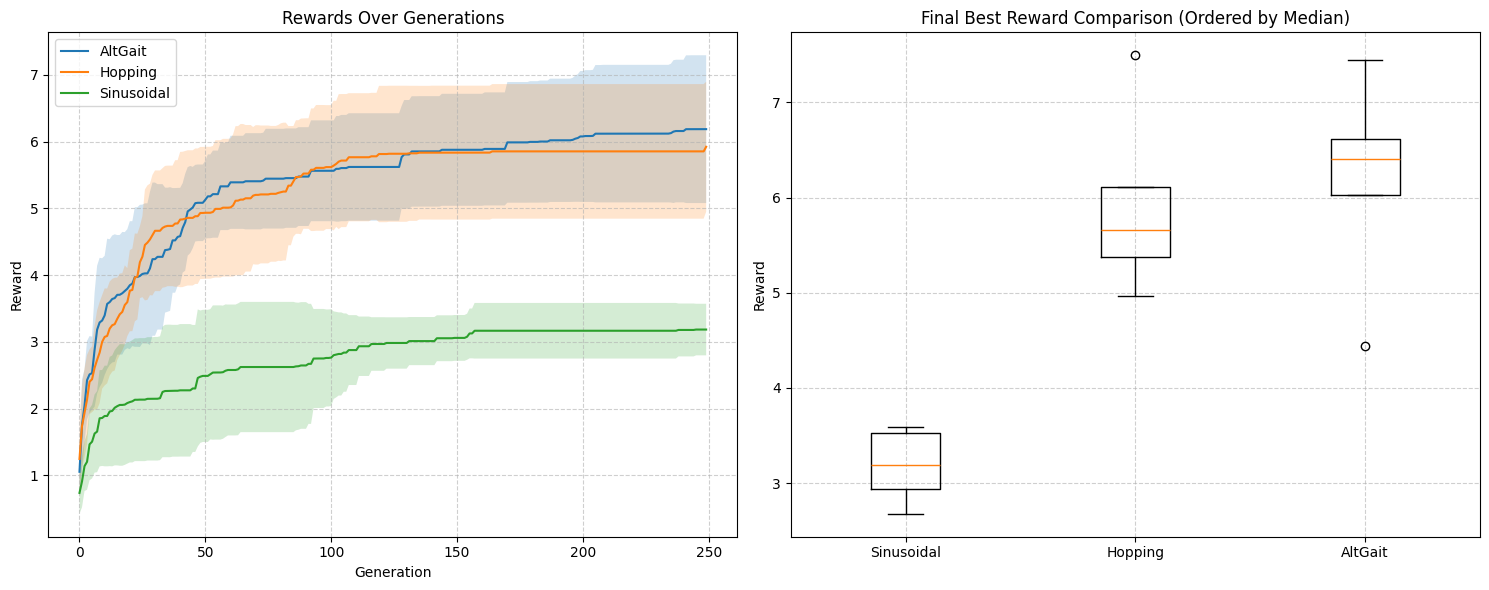

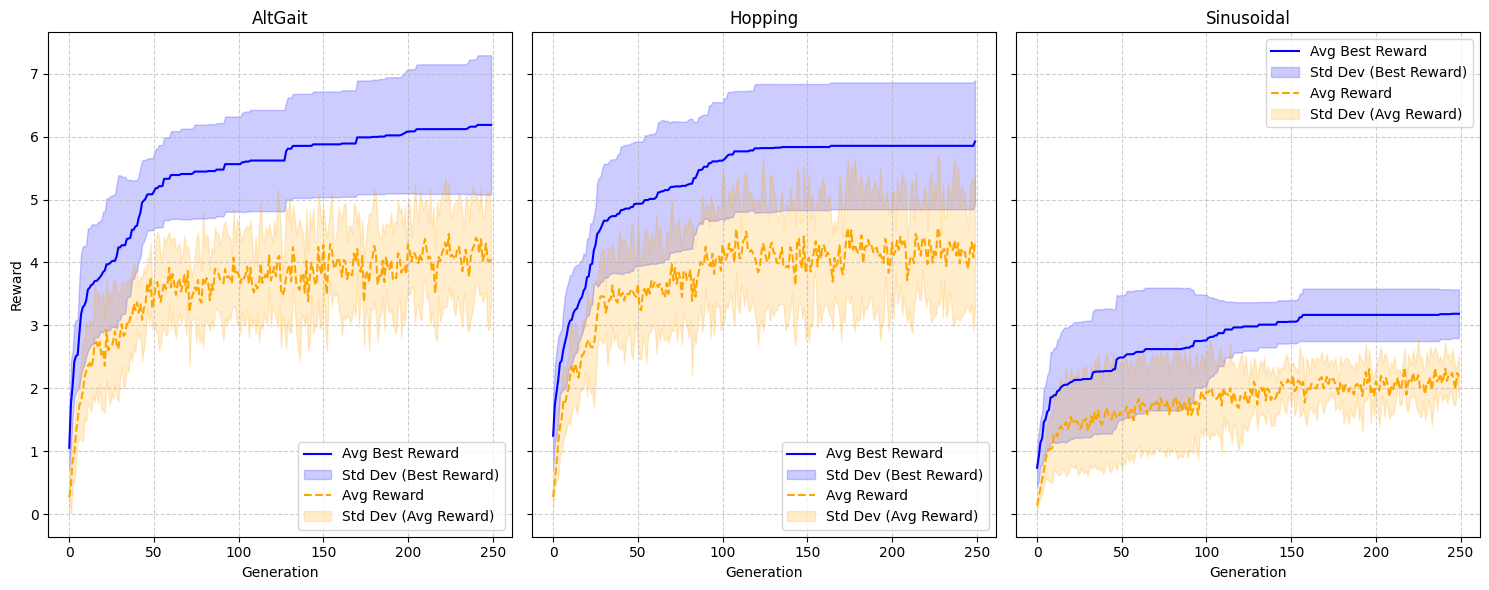

Algorithm: EA_alt_gait_controller_Test_D12_M04_23_02
Average Best Fitness: 6.19 ± 1.11
Average Best Reward: 6.19 ± 1.11
Average of Average Rewards: 3.61
--------------------------------------------------
Algorithm: EA_hopping_controller_Test_D12_M04_23_31
Average Best Fitness: 5.92 ± 0.97
Average Best Reward: 5.92 ± 0.97
Average of Average Rewards: 3.78
--------------------------------------------------
Algorithm: EA_sinusoidal_controller_Test_D12_M04_16_48
Average Best Fitness: 3.18 ± 0.39
Average Best Reward: 3.18 ± 0.39
Average of Average Rewards: 1.82
--------------------------------------------------


In [162]:
algorithms = [ea_alt_gait, ea_hopping, ea_sinusoidal]
labels = ["AltGait", "Hopping", "Sinusoidal"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [163]:
groups = [
    ea_alt_gait_reward,
    ea_hopping_reward,
    ea_sinusoidal_reward
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)

Kruskal-Wallis Test: H-statistic = 9.500, p-value = 0.00865

Pairwise Mann-Whitney U Tests with Bonferroni correction:
             AltGait   Hopping  Sinusoidal
AltGait     1.000000  0.690476    0.007937
Hopping     0.690476  1.000000    0.007937
Sinusoidal  0.007937  0.007937    1.000000


## Task 1

In [147]:

#Task 1 - Walker-v0
ea_alt_gait = ExperimentLoader("results/task1/Walker-v0/EA_alt_gait_controller_Test_D12_M04_23_02")
ea_hopping = ExperimentLoader("results/task1/Walker-v0/EA_hopping_controller_Test_D12_M04_23_31")
ea_sinusoidal = ExperimentLoader("results/task1/Walker-v0/EA_sinusoidal_controller_Test_D12_M04_16_48")

random_search = ExperimentLoader("results/task1/Walker-v0/(0)RandomSearch_D20_M04_11_26")
ea_swapmut_1pcross = ExperimentLoader("results/task1/Walker-v0/(1.1)GeneticAl_SwapMut_1PCross_D19_M04_10_20")
ea_swapmut_unifcross = ExperimentLoader("results/task1/Walker-v0/(1.2)GeneticAl_SwapMut_UnifCross_D19_M04_17_46")
ea_flipmut_1pcross = ExperimentLoader("results/task1/Walker-v0/(1.3)GeneticAl_FlipMut_1PCross_D19_M04_23_45")
ea_flipmut_unifcross = ExperimentLoader("results/task1/Walker-v0/(1.4)GeneticAl_FlipMut_UnifCross_D19_M04_23_27")

ea_flipmut_1pcross_010 = ExperimentLoader("results/task1/Walker-v0/(1.3M010)GeneticAl_FlipMut_1PCross_D20_M04_19_55")
ea_flipmut_1pcross_015 = ExperimentLoader("results/task1/Walker-v0/(1.3M015)GeneticAl_FlipMut_1PCross_D20_M04_13_49")

ea_flipmut_1pcross_T2 = ExperimentLoader("results/task1/Walker-v0/(1.3M015T2)GeneticAl_FlipMut_1PCross_D21_M04_22_40")
ea_flipmut_1pcross_T6 = ExperimentLoader("results/task1/Walker-v0/(1.3M015T6)GeneticAl_FlipMut_1PCross_D21_M04_11_15")

ea_flipmut_1pcross_E1 = ExperimentLoader("results/task1/Walker-v0/(1.3M015E1)GeneticAl_FlipMut_1PCross_D21_M04_14_48")


alt_rewards = ea_alt_gait.get_all_best_rewards()
hopping_rewards = ea_hopping.get_all_best_rewards()
sinusoidal_rewards = ea_sinusoidal.get_all_best_rewards()

random_rewards = random_search.get_all_best_rewards()
ea_swapmut_1pcross_rewards = ea_swapmut_1pcross.get_all_best_rewards()
ea_swapmut_unifcross_rewards = ea_swapmut_unifcross.get_all_best_rewards()
ea_flipmut_1pcross_rewards = ea_flipmut_1pcross.get_all_best_rewards()
ea_flipmut_unifcross_rewards = ea_flipmut_unifcross.get_all_best_rewards()

ea_flipmut_1pcross_010_rewards = ea_flipmut_1pcross_010.get_all_best_rewards()
ea_flipmut_1pcross_015_rewards = ea_flipmut_1pcross_015.get_all_best_rewards()

ea_flipmut_1pcross_T2_rewards = ea_flipmut_1pcross_T2.get_all_best_rewards()
ea_flipmut_1pcross_T6_rewards = ea_flipmut_1pcross_T6.get_all_best_rewards()

ea_flipmut_1pcross_E1_rewards = ea_flipmut_1pcross_E1.get_all_best_rewards()

#Task 1 - BridgeWalker-v0

random_search_bridge = ExperimentLoader("results/task1/BridgeWalker-v0/(0)RandomSearch_D23_M04_14_01")
ea_flipmut_unifcross_bridge = ExperimentLoader("results/task1/BridgeWalker-v0/(1.2)GeneticAl_FlipMut_UnifCross_D24_M04_00_45")
ea_flipmut_1pcross_bridge = ExperimentLoader("results/task1/BridgeWalker-v0/(1.1)GeneticAl_FlipMut_1PCross_D22_M04_23_46")


random_rewards_bridge = random_search_bridge.get_all_best_rewards()
ea_flipmut_unifcross_bridge_rewards = ea_flipmut_unifcross_bridge.get_all_best_rewards()
ea_flipmut_1pcross_bridge_rewards = ea_flipmut_1pcross_bridge.get_all_best_rewards()




### Comparison 1: Which is the best algorithm for evolving a structure with a fixed controller in Walker-v0

/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


Algorithm: Random Search, Average of Average Rewards: -0.02
Algorithm: Swap, 1 Point, Average of Average Rewards: 3.14
Algorithm: Swap, Uniform, Average of Average Rewards: 3.55
Algorithm: Flip, 1 Point, Average of Average Rewards: 3.60
Algorithm: Flip, Uniform, Average of Average Rewards: 3.85


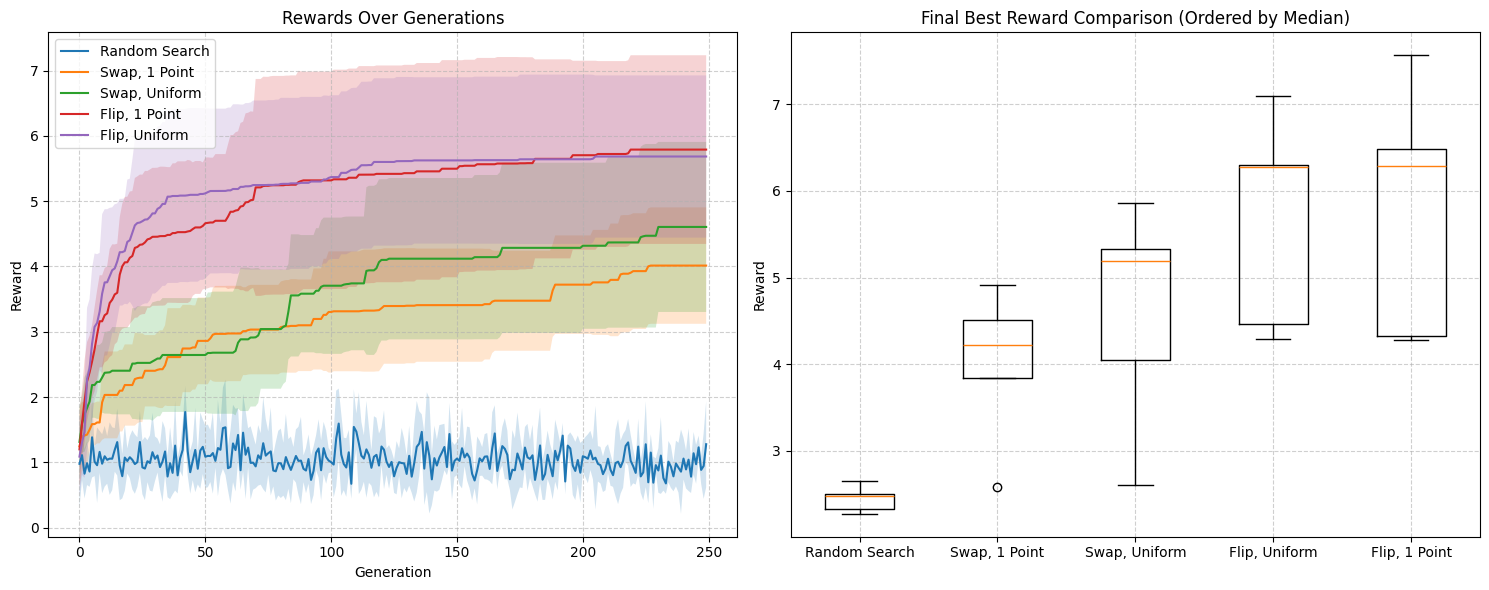

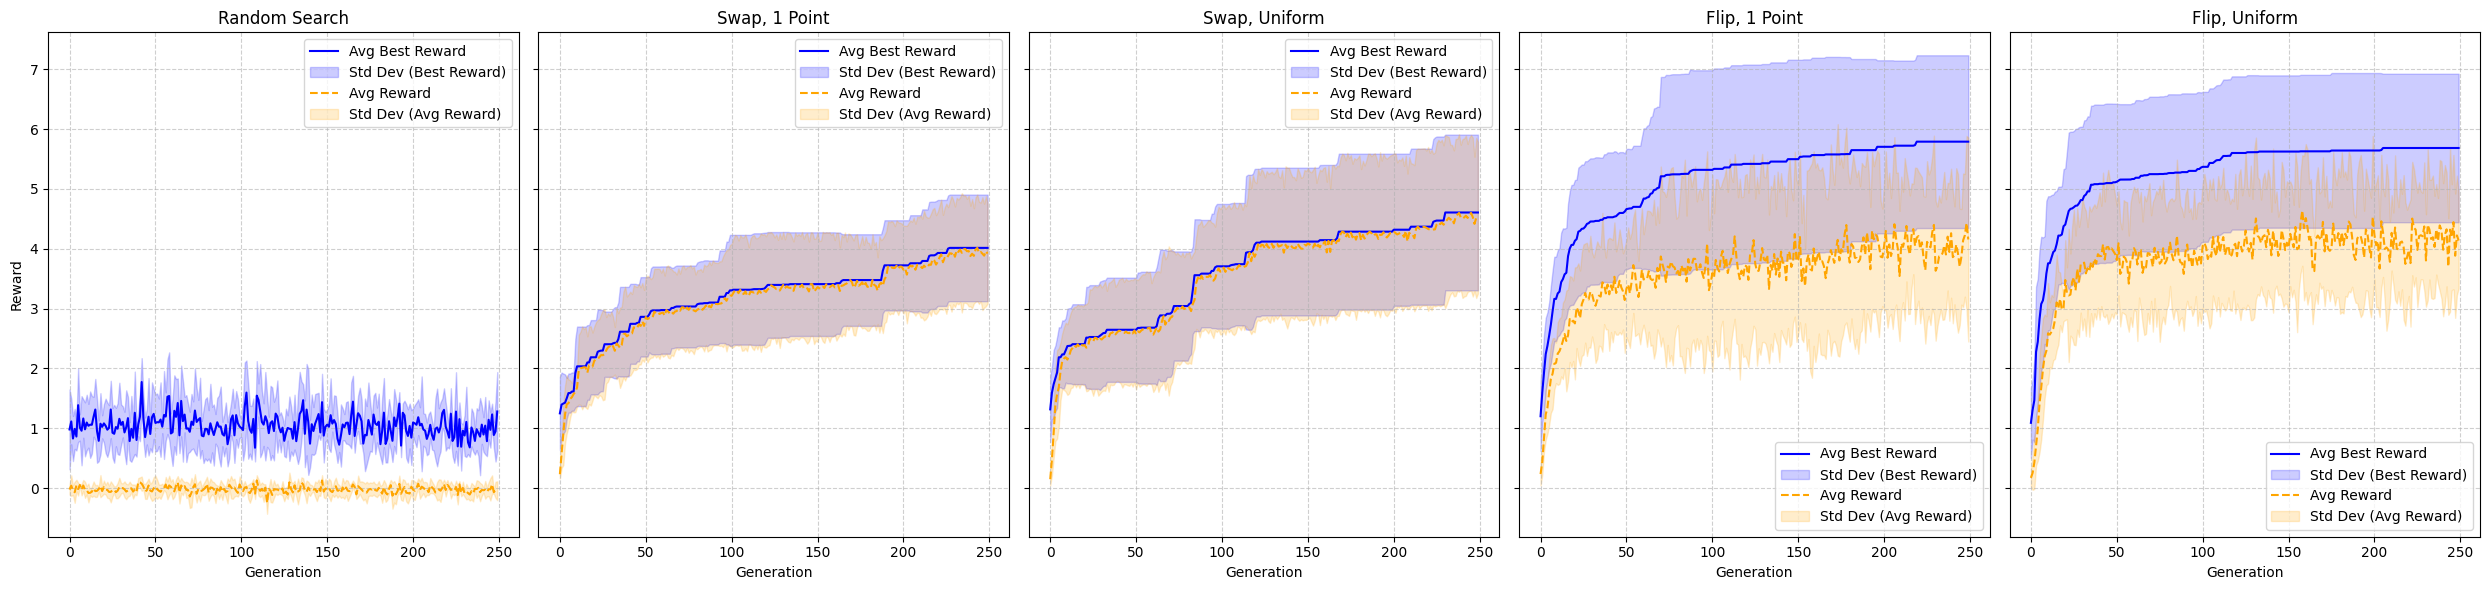

Algorithm: (0)RandomSearch_D20_M04_11_26
Average Best Fitness: 2.44 ± 0.15
Average Best Reward: 2.44 ± 0.15
Average of Average Rewards: -0.02
--------------------------------------------------
Algorithm: (1.1)GeneticAl_SwapMut_1PCross_D19_M04_10_20
Average Best Fitness: 4.01 ± 0.89
Average Best Reward: 4.01 ± 0.89
Average of Average Rewards: 3.14
--------------------------------------------------
Algorithm: (1.2)GeneticAl_SwapMut_UnifCross_D19_M04_17_46
Average Best Fitness: 4.61 ± 1.30
Average Best Reward: 4.61 ± 1.30
Average of Average Rewards: 3.55
--------------------------------------------------
Algorithm: (1.3)GeneticAl_FlipMut_1PCross_D19_M04_23_45
Average Best Fitness: 5.79 ± 1.44
Average Best Reward: 5.79 ± 1.44
Average of Average Rewards: 3.60
--------------------------------------------------
Algorithm: (1.4)GeneticAl_FlipMut_UnifCross_D19_M04_23_27
Average Best Fitness: 5.68 ± 1.24
Average Best Reward: 5.68 ± 1.24
Average of Average Rewards: 3.85
--------------------------

In [138]:
algorithms = [random_search, ea_swapmut_1pcross, ea_swapmut_unifcross, ea_flipmut_1pcross, ea_flipmut_unifcross]
labels = ["Random Search", "Swap, 1 Point", "Swap, Uniform", "Flip, 1 Point", "Flip, Uniform"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [139]:
groups = [
    random_rewards,
    ea_swapmut_1pcross_rewards,
    ea_swapmut_unifcross_rewards,
    ea_flipmut_1pcross_rewards,
    ea_flipmut_unifcross_rewards,
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)


Kruskal-Wallis Test: H-statistic = 14.599, p-value = 0.00561

Pairwise Mann-Whitney U Tests with Bonferroni correction:
               Random Search  Swap, 1 Point  Swap, Uniform  Flip, 1 Point  \
Random Search       1.000000       0.015873       0.015873       0.007937   
Swap, 1 Point       0.015873       1.000000       0.309524       0.095238   
Swap, Uniform       0.015873       0.309524       1.000000       0.222222   
Flip, 1 Point       0.007937       0.095238       0.222222       1.000000   
Flip, Uniform       0.007937       0.095238       0.222222       1.000000   

               Flip, Uniform  
Random Search       0.007937  
Swap, 1 Point       0.095238  
Swap, Uniform       0.222222  
Flip, 1 Point       1.000000  
Flip, Uniform       1.000000  


### Comparison 2: Mutation rate optimization in Walker-v0 with GA with Flip Mutation and 1 Point Crossover

Algorithm: Flip, 1 Point, MR = 0.05, Average of Average Rewards: 3.60
Algorithm: Flip, 1 Point, MR = 0.10, Average of Average Rewards: 2.56
Algorithm: Flip, 1 Point, MR = 0.15, Average of Average Rewards: 2.15


/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


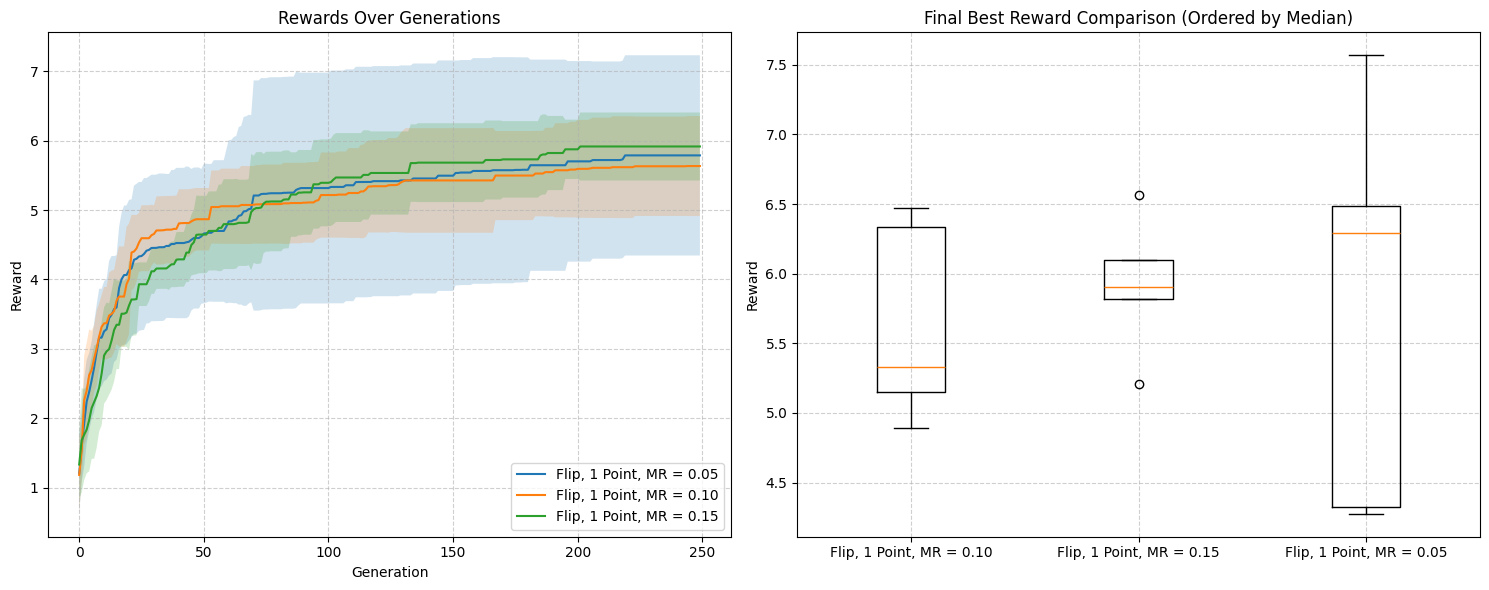

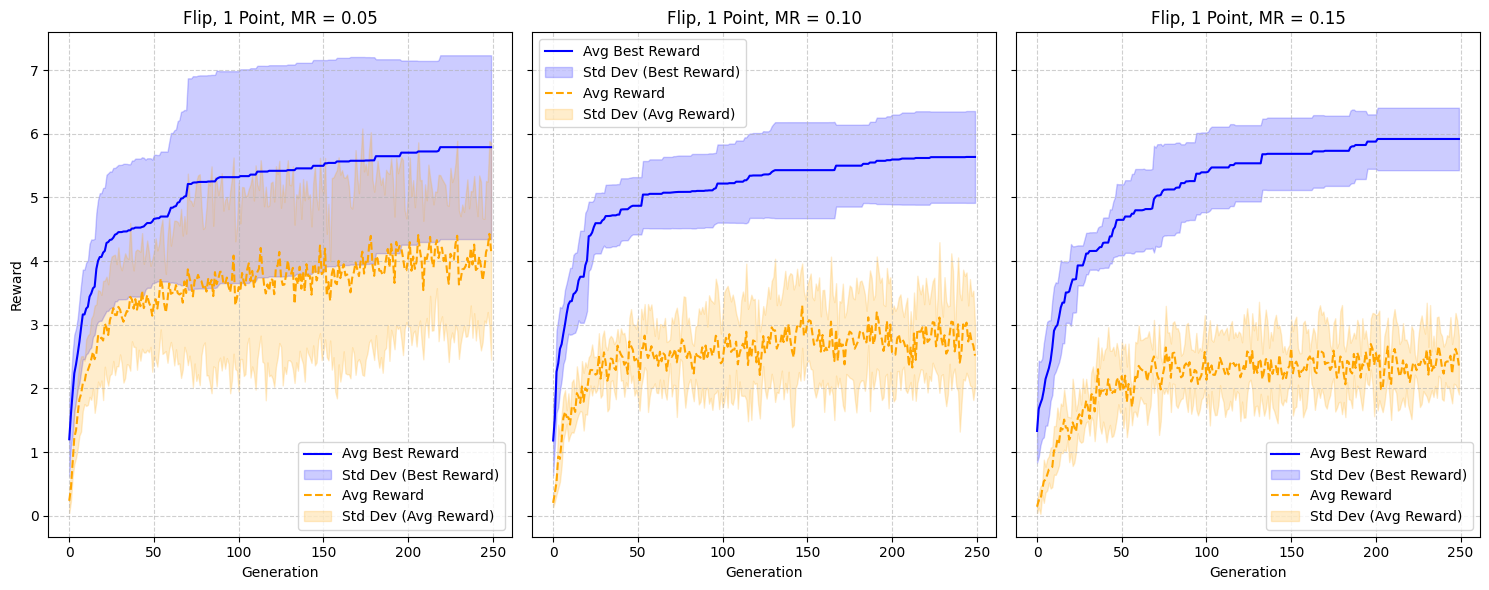

Algorithm: (1.3)GeneticAl_FlipMut_1PCross_D19_M04_23_45
Average Best Fitness: 5.79 ± 1.44
Average Best Reward: 5.79 ± 1.44
Average of Average Rewards: 3.60
--------------------------------------------------
Algorithm: (1.3M010)GeneticAl_FlipMut_1PCross_D20_M04_19_55
Average Best Fitness: 5.64 ± 0.72
Average Best Reward: 5.64 ± 0.72
Average of Average Rewards: 2.56
--------------------------------------------------
Algorithm: (1.3M015)GeneticAl_FlipMut_1PCross_D20_M04_13_49
Average Best Fitness: 5.92 ± 0.49
Average Best Reward: 5.92 ± 0.49
Average of Average Rewards: 2.15
--------------------------------------------------


In [140]:
algorithms = [ea_flipmut_1pcross, ea_flipmut_1pcross_010, ea_flipmut_1pcross_015]
labels = ["Flip, 1 Point, MR = 0.05", "Flip, 1 Point, MR = 0.10", "Flip, 1 Point, MR = 0.15"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [141]:
groups = [
    ea_flipmut_1pcross_rewards,
    ea_flipmut_1pcross_010_rewards,
    ea_flipmut_1pcross_015_rewards
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)

Kruskal-Wallis Test: H-statistic = 0.260, p-value = 0.87810

Pairwise Mann-Whitney U Tests with Bonferroni correction:
                          Flip, 1 Point, MR = 0.05  Flip, 1 Point, MR = 0.10  \
Flip, 1 Point, MR = 0.05                       1.0                  1.000000   
Flip, 1 Point, MR = 0.10                       1.0                  1.000000   
Flip, 1 Point, MR = 0.15                       1.0                  0.547619   

                          Flip, 1 Point, MR = 0.15  
Flip, 1 Point, MR = 0.05                  1.000000  
Flip, 1 Point, MR = 0.10                  0.547619  
Flip, 1 Point, MR = 0.15                  1.000000  


### Comparison 3: Tournament size optimization in Walker-v0 with GA with Flip Mutation, 1 Point Crossover and Mutation Rate = 0.15

Algorithm: Flip, 1 Point, T = 4, Average of Average Rewards: 2.15
Algorithm: Flip, 1 Point, T = 2, Average of Average Rewards: 2.04
Algorithm: Flip, 1 Point, T = 6, Average of Average Rewards: 2.15


/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


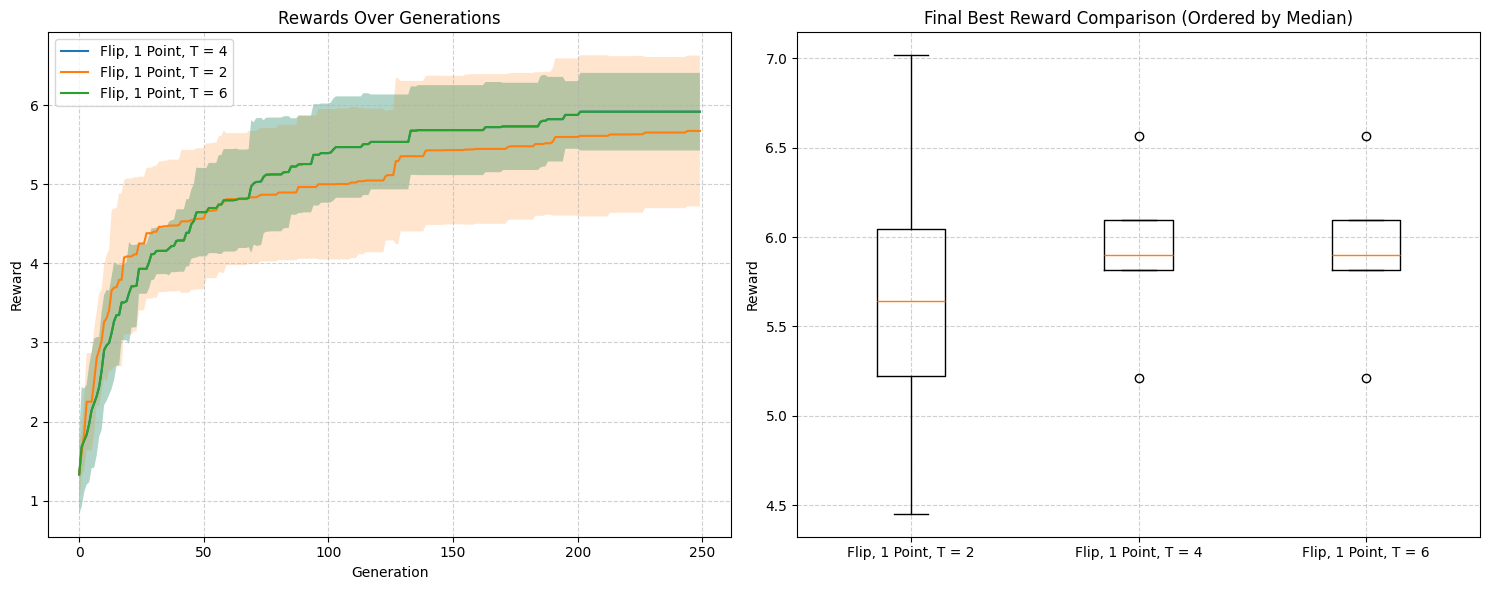

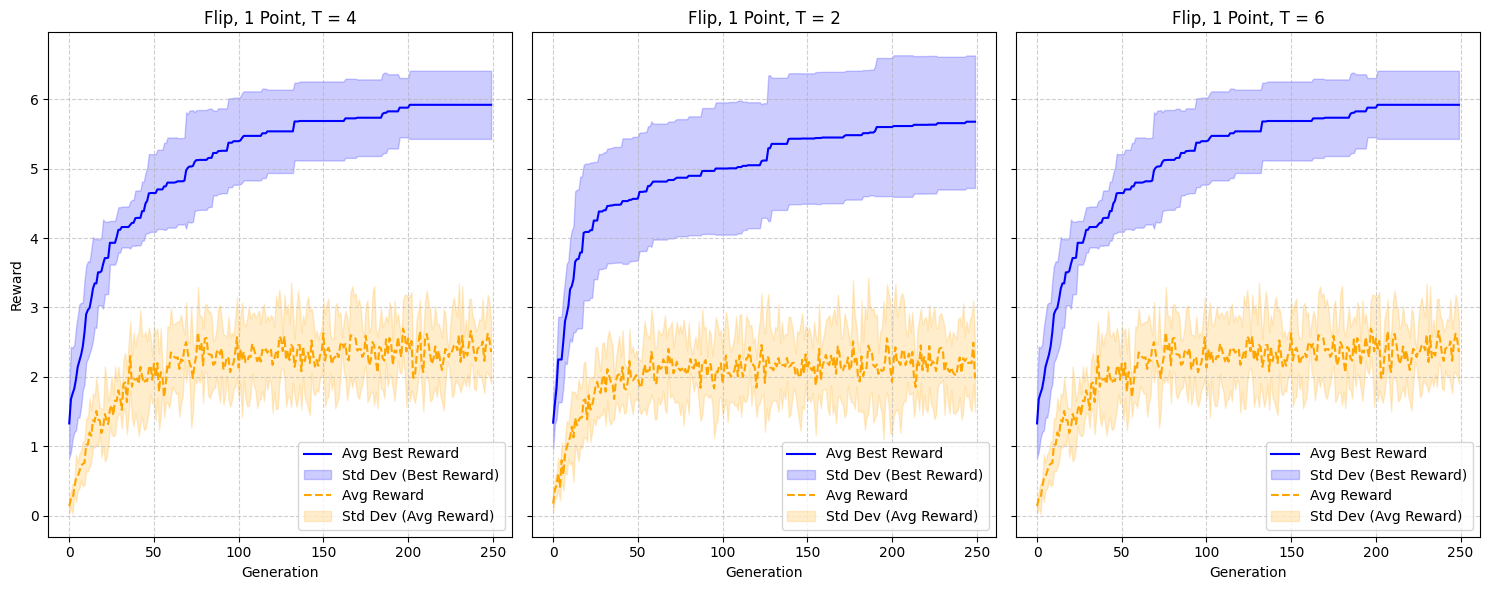

Algorithm: (1.3M015)GeneticAl_FlipMut_1PCross_D20_M04_13_49
Average Best Fitness: 5.92 ± 0.49
Average Best Reward: 5.92 ± 0.49
Average of Average Rewards: 2.15
--------------------------------------------------
Algorithm: (1.3M015T2)GeneticAl_FlipMut_1PCross_D21_M04_22_40
Average Best Fitness: 5.67 ± 0.95
Average Best Reward: 5.67 ± 0.95
Average of Average Rewards: 2.04
--------------------------------------------------
Algorithm: (1.3M015T6)GeneticAl_FlipMut_1PCross_D21_M04_11_15
Average Best Fitness: 5.92 ± 0.49
Average Best Reward: 5.92 ± 0.49
Average of Average Rewards: 2.15
--------------------------------------------------


In [142]:
algorithms = [ea_flipmut_1pcross_015, ea_flipmut_1pcross_T2, ea_flipmut_1pcross_T6]
labels = ["Flip, 1 Point, T = 4", "Flip, 1 Point, T = 2", "Flip, 1 Point, T = 6"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [143]:
groups = [
    ea_flipmut_1pcross_015_rewards,
    ea_flipmut_1pcross_T2_rewards,
    ea_flipmut_1pcross_T6_rewards
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)

Kruskal-Wallis Test: H-statistic = 0.378, p-value = 0.82763

Pairwise Mann-Whitney U Tests with Bonferroni correction:
                      Flip, 1 Point, T = 4  Flip, 1 Point, T = 2  \
Flip, 1 Point, T = 4              1.000000              0.690476   
Flip, 1 Point, T = 2              0.690476              1.000000   
Flip, 1 Point, T = 6              1.000000              0.690476   

                      Flip, 1 Point, T = 6  
Flip, 1 Point, T = 4              1.000000  
Flip, 1 Point, T = 2              0.690476  
Flip, 1 Point, T = 6              1.000000  


### Comparison 4: Elitism size optimization in Walker-v0 with GA with Flip Mutation, 1 Point Crossover, Mutation Rate = 0.15 and Tournament Size = 4

Algorithm: Flip, 1 Point, E = 2, Average of Average Rewards: 2.15
Algorithm: Flip, 1 Point, E = 1, Average of Average Rewards: 1.81


/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


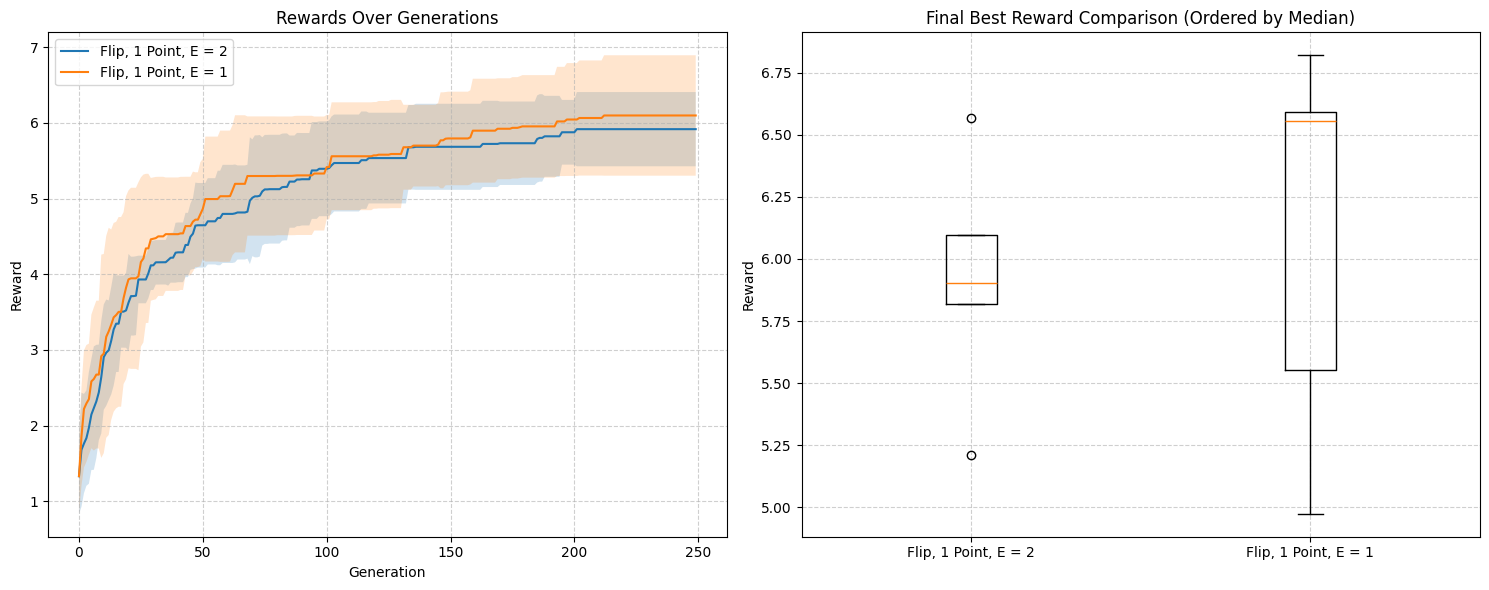

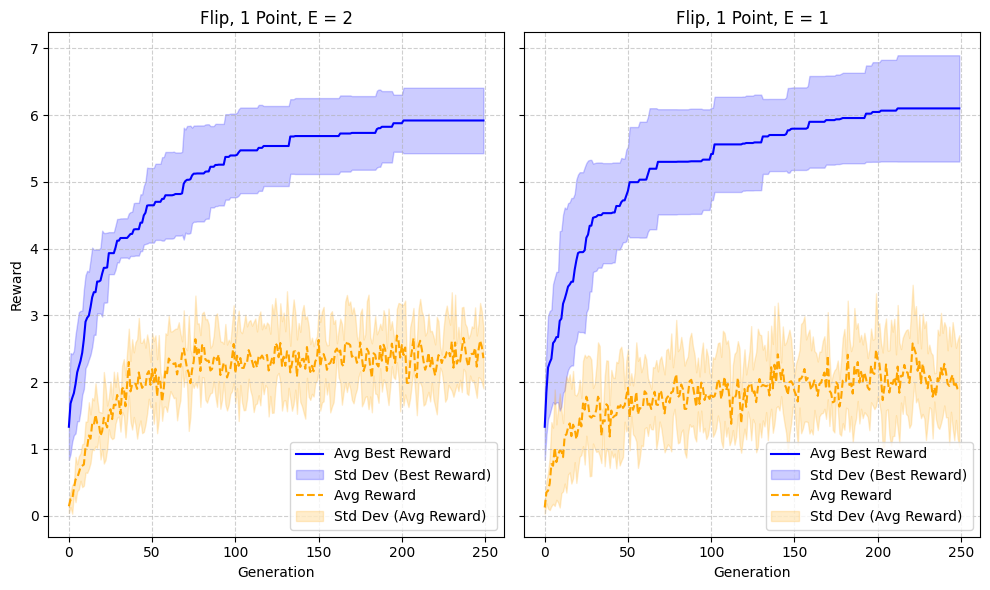

Algorithm: (1.3M015)GeneticAl_FlipMut_1PCross_D20_M04_13_49
Average Best Fitness: 5.92 ± 0.49
Average Best Reward: 5.92 ± 0.49
Average of Average Rewards: 2.15
--------------------------------------------------
Algorithm: (1.3M015E1)GeneticAl_FlipMut_1PCross_D21_M04_14_48
Average Best Fitness: 6.10 ± 0.80
Average Best Reward: 6.10 ± 0.80
Average of Average Rewards: 1.81
--------------------------------------------------


In [151]:
algorithms = [ea_flipmut_1pcross_015, ea_flipmut_1pcross_E1]
labels = ["Flip, 1 Point, E = 2", "Flip, 1 Point, E = 1"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [152]:
groups = [
    ea_flipmut_1pcross_015_rewards,
    ea_flipmut_1pcross_E1_rewards
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)

Kruskal-Wallis Test: H-statistic = 0.273, p-value = 0.60151

Pairwise Mann-Whitney U Tests with Bonferroni correction:
                      Flip, 1 Point, E = 2  Flip, 1 Point, E = 1
Flip, 1 Point, E = 2              1.000000              0.690476
Flip, 1 Point, E = 1              0.690476              1.000000


### Comparison 5: Which is the best algorithm for evolving a structure with a fixed controller in BridgeWalker-v0

Algorithm: Random Search, Average of Average Rewards: -0.10
Algorithm: Flip, 1 Point, Average of Average Rewards: 0.82
Algorithm: Flip, Uniform, Average of Average Rewards: 0.91


/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


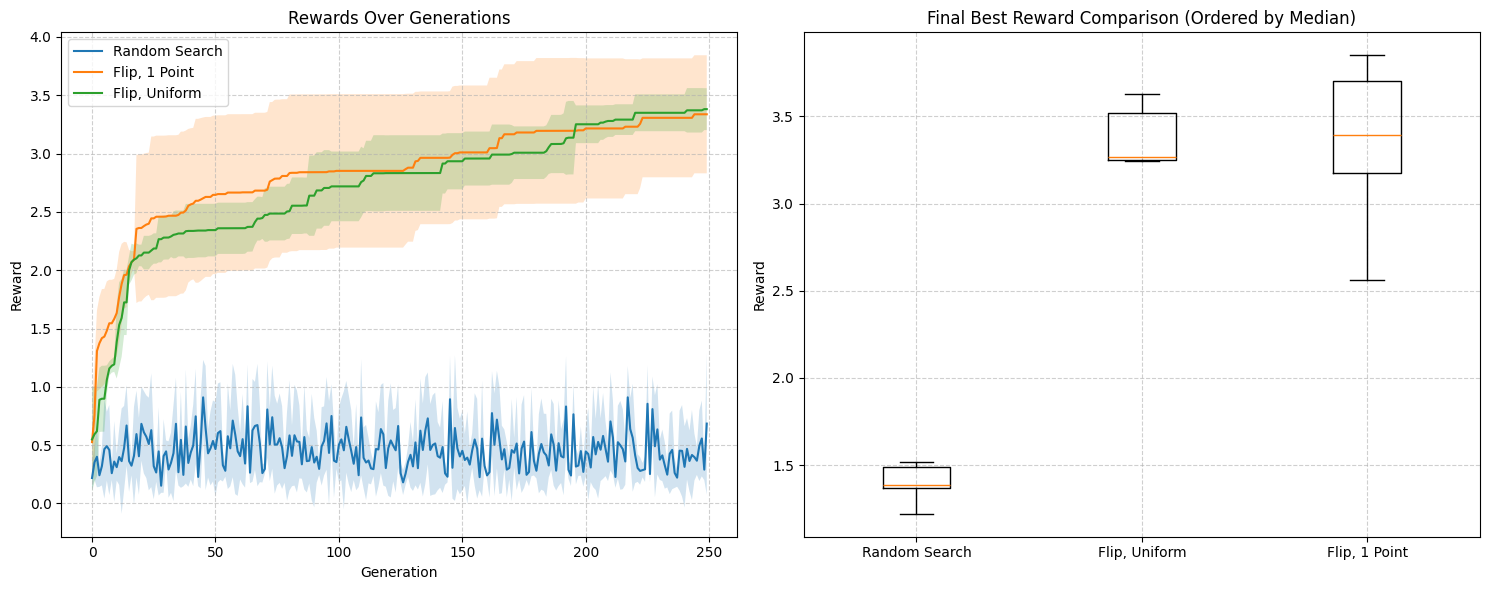

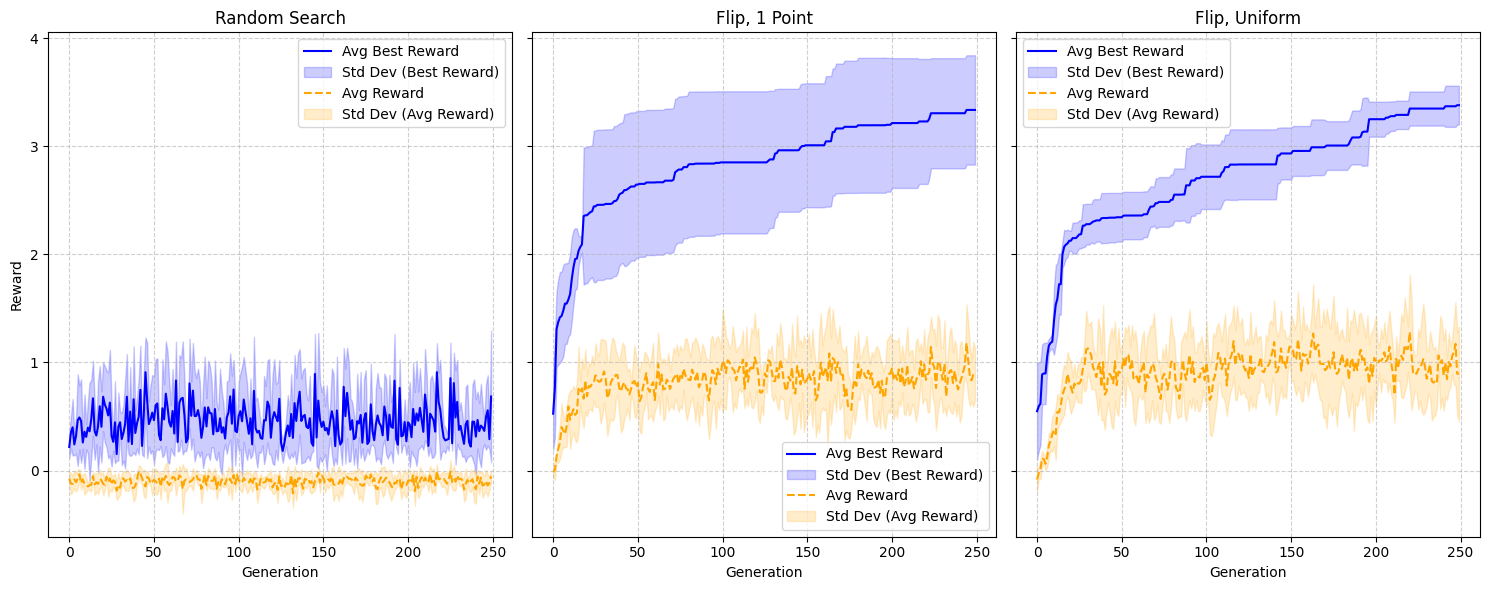

Algorithm: (0)RandomSearch_D23_M04_14_01
Average Best Fitness: 1.40 ± 0.12
Average Best Reward: 1.40 ± 0.12
Average of Average Rewards: -0.10
--------------------------------------------------
Algorithm: (1.1)GeneticAl_FlipMut_1PCross_D22_M04_23_46
Average Best Fitness: 3.34 ± 0.51
Average Best Reward: 3.34 ± 0.51
Average of Average Rewards: 0.82
--------------------------------------------------
Algorithm: (1.2)GeneticAl_FlipMut_UnifCross_D24_M04_00_45
Average Best Fitness: 3.38 ± 0.18
Average Best Reward: 3.38 ± 0.18
Average of Average Rewards: 0.91
--------------------------------------------------


In [154]:
algorithms = [random_search_bridge, ea_flipmut_1pcross_bridge, ea_flipmut_unifcross_bridge]
labels = ["Random Search", "Flip, 1 Point", "Flip, Uniform"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [155]:
groups = [
    random_rewards_bridge,
    ea_flipmut_1pcross_bridge_rewards,
    ea_flipmut_unifcross_bridge_rewards
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)

Kruskal-Wallis Test: H-statistic = 9.380, p-value = 0.00919

Pairwise Mann-Whitney U Tests with Bonferroni correction:
               Random Search  Flip, 1 Point  Flip, Uniform
Random Search       1.000000       0.007937       0.007937
Flip, 1 Point       0.007937       1.000000       1.000000
Flip, Uniform       0.007937       1.000000       1.000000


## Task 2

Load data from experiments

In [ ]:
#Task 2 - DownStepper-v0
bestGATask1 = ExperimentLoader("results/task2/DownStepper-v0/(task1)BestGATask1_D01_M05_20_59")
deRand1Bin = ExperimentLoader("results/task2/DownStepper-v0/(2.1)DeRand1Bin_D29_M04_19_59")
deBest1Bin = ExperimentLoader("results/task2/DownStepper-v0/(2.2)DeBest1Bin_D30_M04_10_17")
cmaES = ExperimentLoader("results/task2/DownStepper-v0/(3)CMA-ES_D04_M05_12_23")
randomSearch = ExperimentLoader("results/task2/DownStepper-v0/(0)Random_Search_D29_M04_16_51")
muPlusLambda = ExperimentLoader("results/task2/DownStepper-v0/(1)mupluslambda_D03_M05_12_26")

bestGATask1_rewards = bestGATask1.get_all_best_rewards()
deRand1Bin_rewards = deRand1Bin.get_all_best_rewards()
deBest1Bin_rewards = deBest1Bin.get_all_best_rewards()
cmaES_rewards = cmaES.get_all_best_rewards()
randomSearch_rewards = randomSearch.get_all_best_rewards()
muPlusLambda_rewards = muPlusLambda.get_all_best_rewards()

GA500 = ExperimentLoader("results/task2/DownStepper-v0/(500)(task1)BestGATask1_D04_M05_23_00")
DE500 = ExperimentLoader("results/task2/DownStepper-v0/(500)(2.1)DeRand1Bin_D05_M05_11_33")
CMAES500 = ExperimentLoader("results/task2/DownStepper-v0/(500)(3)CMA-ES_D05_M05_00_01")

GA500_rewards = GA500.get_all_best_rewards()
DE500_rewards = DE500.get_all_best_rewards()
CMAES500_rewards = CMAES500.get_all_best_rewards()

### Comparison 1: Which is the best algorithm for evolving the controller of a fixed structure for DownStepper-v0?

Algorithm: Random Search, Average of Average Rewards: -0.88
Algorithm: DE Random, Average of Average Rewards: 1.51
Algorithm: DE Best, Average of Average Rewards: 1.76
Algorithm: CMA-ES, Average of Average Rewards: 0.62
Algorithm: mu+lambda-ES, Average of Average Rewards: 2.13
Algorithm: GA, Average of Average Rewards: 1.43


/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


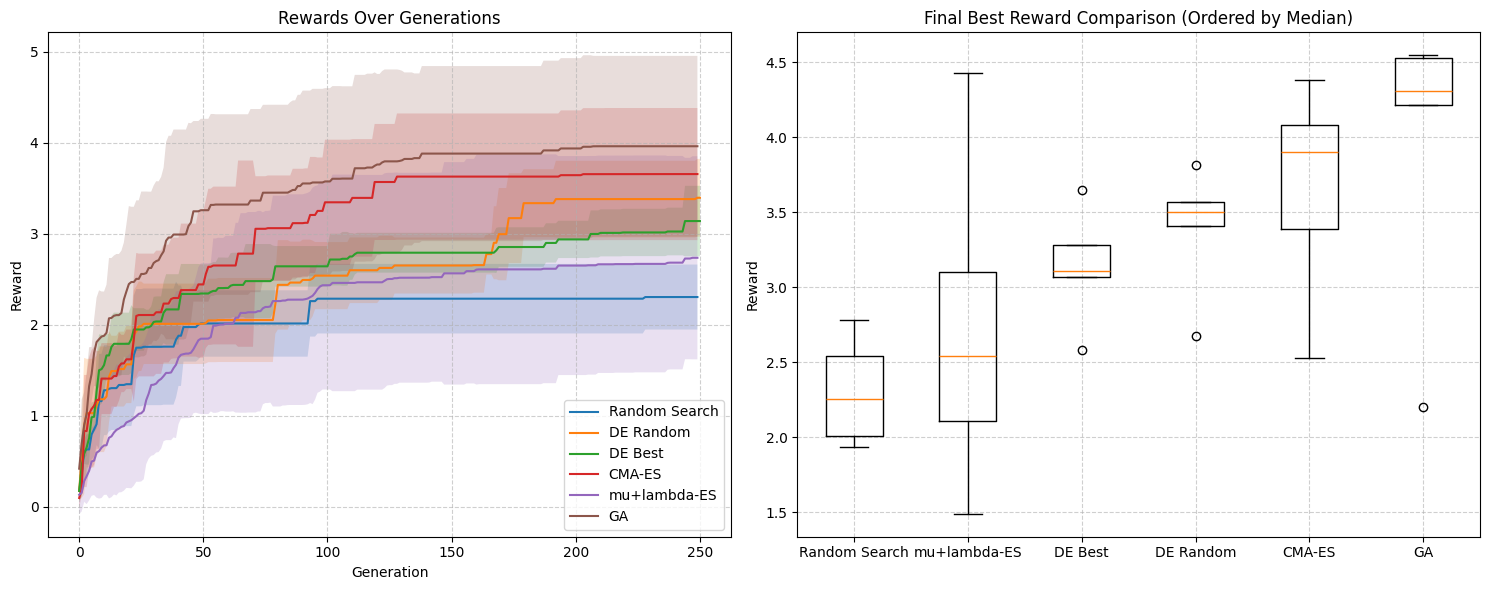

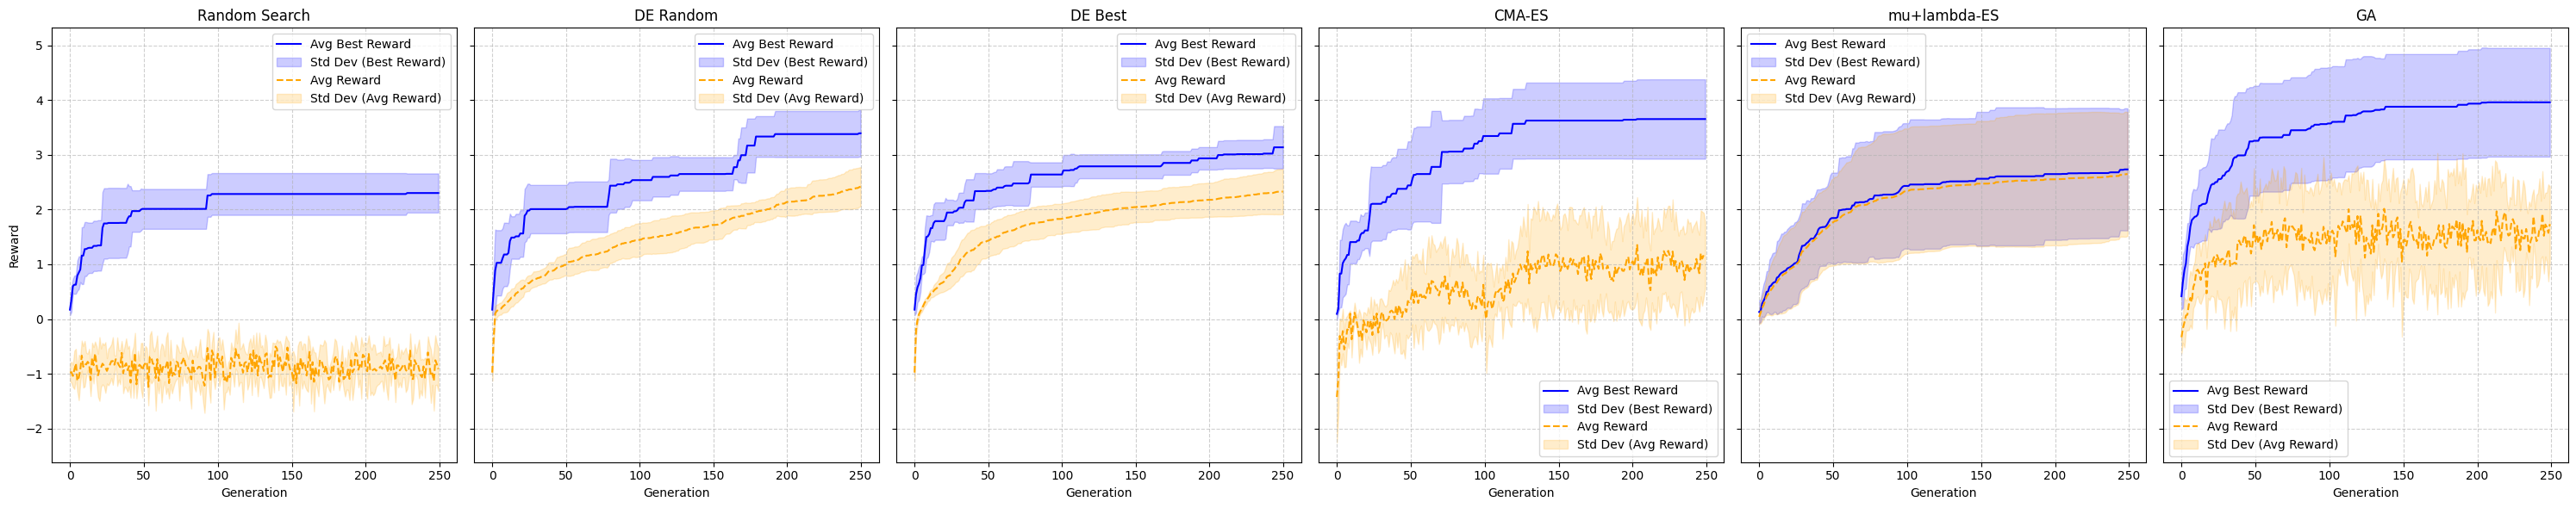

Algorithm: (0)Random_Search_D29_M04_16_51
Average Best Fitness: 2.30 ± 0.36
Average Best Reward: 2.30 ± 0.36
Average of Average Rewards: -0.88
--------------------------------------------------
Algorithm: (2.1)DeRand1Bin_D29_M04_19_59
Average Best Fitness: 3.39 ± 0.43
Average Best Reward: 3.39 ± 0.43
Average of Average Rewards: 1.51
--------------------------------------------------
Algorithm: (2.2)DeBest1Bin_D30_M04_10_17
Average Best Fitness: 3.14 ± 0.39
Average Best Reward: 3.14 ± 0.39
Average of Average Rewards: 1.76
--------------------------------------------------
Algorithm: (3)CMA-ES_D04_M05_12_23
Average Best Fitness: 3.65 ± 0.73
Average Best Reward: 3.65 ± 0.73
Average of Average Rewards: 0.62
--------------------------------------------------
Algorithm: (1)mupluslambda_D03_M05_12_26
Average Best Fitness: 2.73 ± 1.12
Average Best Reward: 2.73 ± 1.12
Average of Average Rewards: 2.13
--------------------------------------------------
Algorithm: (task1)BestGATask1_D01_M05_20_59


In [157]:
algorithms = [randomSearch, deRand1Bin, deBest1Bin, cmaES, muPlusLambda, bestGATask1]
labels = ["Random Search", "DE Random", "DE Best", "CMA-ES", "mu+lambda-ES", "GA"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [158]:
groups = [
    randomSearch_rewards,
    deRand1Bin_rewards,
    deBest1Bin_rewards,
    cmaES_rewards,
    muPlusLambda_rewards,
    bestGATask1_rewards
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)

Kruskal-Wallis Test: H-statistic = 11.906, p-value = 0.03610

Pairwise Mann-Whitney U Tests with Bonferroni correction:
               Random Search  DE Random   DE Best    CMA-ES  mu+lambda-ES  \
Random Search       1.000000   0.015873  0.015873  0.031746      0.547619   
DE Random           0.015873   1.000000  0.309524  0.547619      0.222222   
DE Best             0.015873   0.309524  1.000000  0.222222      0.309524   
CMA-ES              0.031746   0.547619  0.222222  1.000000      0.309524   
mu+lambda-ES        0.547619   0.222222  0.309524  0.309524      1.000000   
GA                  0.055556   0.150794  0.150794  0.309524      0.150794   

                     GA  
Random Search  0.055556  
DE Random      0.150794  
DE Best        0.150794  
CMA-ES         0.309524  
mu+lambda-ES   0.150794  
GA             1.000000  


### Comparison 2: Doubling the budget(250->500 gens), which is the best algorithm for DownStepper-v0?

Algorithm: GA 500, Average of Average Rewards: 1.51
Algorithm: DE 500, Average of Average Rewards: 2.12
Algorithm: CMA-ES 500, Average of Average Rewards: 0.95


/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_35450/3853532978.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sorted_groups, labels=sorted_labels)


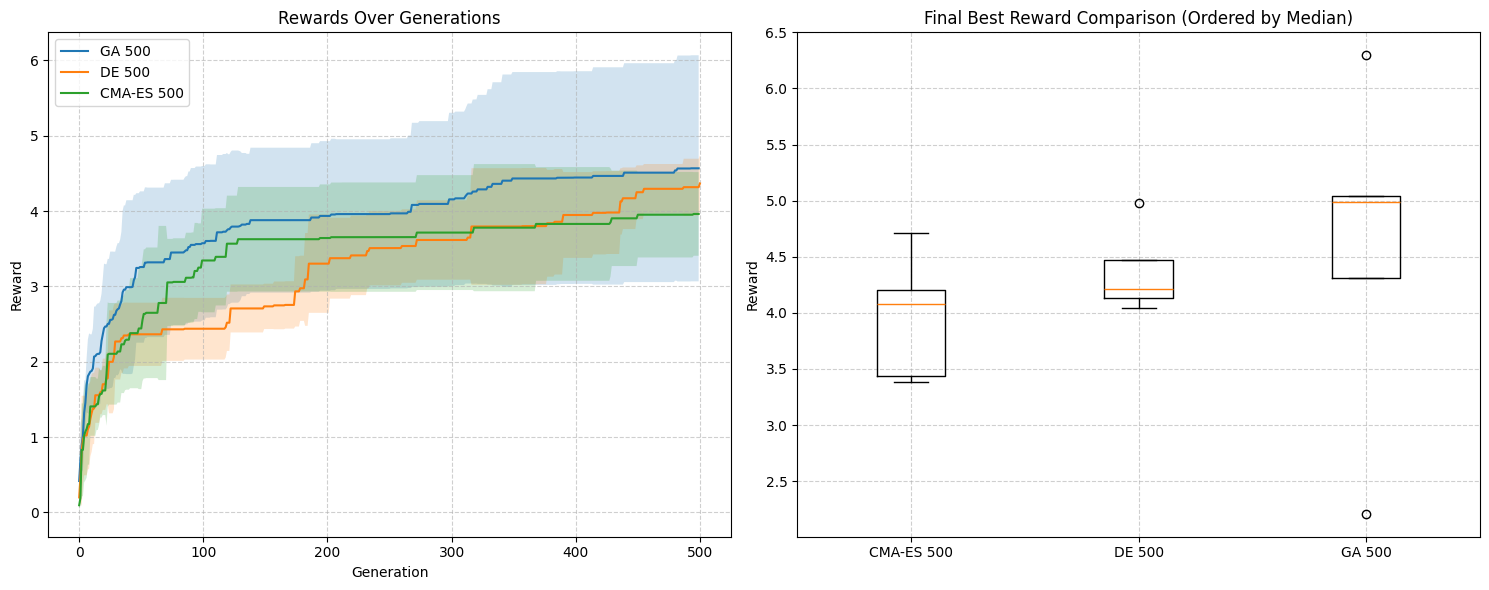

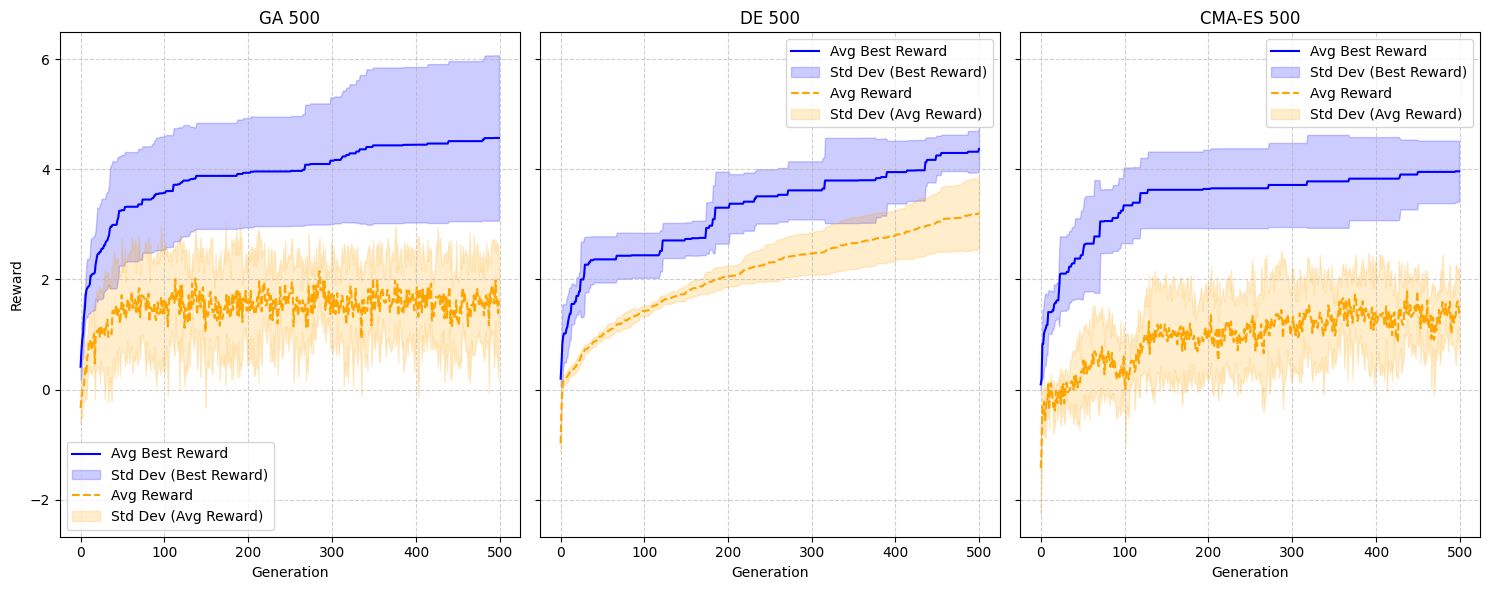

Algorithm: (500)(task1)BestGATask1_D04_M05_23_00
Average Best Fitness: 4.57 ± 1.50
Average Best Reward: 4.57 ± 1.50
Average of Average Rewards: 1.51
--------------------------------------------------
Algorithm: (500)(2.1)DeRand1Bin_D05_M05_11_33
Average Best Fitness: 4.37 ± 0.38
Average Best Reward: 4.37 ± 0.38
Average of Average Rewards: 2.12
--------------------------------------------------
Algorithm: (500)(3)CMA-ES_D05_M05_00_01
Average Best Fitness: 3.96 ± 0.56
Average Best Reward: 3.96 ± 0.56
Average of Average Rewards: 0.95
--------------------------------------------------


In [159]:
algorithms = [GA500, DE500, CMAES500]
labels = ["GA 500", "DE 500", "CMA-ES 500"]

plot_rewards_and_boxplot_with_avg(algorithms, labels)
plot_rewards_multiple_algorithms(algorithms, labels)


for alg in algorithms:
    print(f"Algorithm: {alg.experiment_path.split('/')[-1]}")
    
    # Average Best Fitness
    avg_fitness, std_fitness = alg.avg_best_fitness_with_std()
    print(f"Average Best Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")
    
    # Average Best Reward
    avg_reward, std_reward = alg.avg_best_reward_with_std()
    print(f"Average Best Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Average of Average Rewards
    all_avg_rewards = []
    for run_folder in alg.run_folders:
        data = alg.run_data_cache.get(run_folder)
        if data and "average_reward_history" in data:
            all_avg_rewards.append(data["average_reward_history"])
    if all_avg_rewards:
        avg_reward_per_gen = np.mean(all_avg_rewards, axis=0)  # Average per generation
        avg_of_avg_rewards = np.mean(avg_reward_per_gen)  # Overall average
        print(f"Average of Average Rewards: {avg_of_avg_rewards:.2f}")
    else:
        print("Average of Average Rewards: N/A (No data available)")
    
    print("-" * 50)

In [160]:
groups = [
    GA500_rewards,
    DE500_rewards,
    CMAES500_rewards
]

kruskal_wallis_result = kruskal_wallis(groups)

print(f"Kruskal-Wallis Test: H-statistic = {kruskal_wallis_result[0]:.3f}, p-value = {kruskal_wallis_result[1]:.5f}")

p_mw=pairwise_mann_whitney_with_bonferroni(groups, labels)

print("\nPairwise Mann-Whitney U Tests with Bonferroni correction:")
print(p_mw)

Kruskal-Wallis Test: H-statistic = 2.880, p-value = 0.23693

Pairwise Mann-Whitney U Tests with Bonferroni correction:
              GA 500    DE 500  CMA-ES 500
GA 500      1.000000  0.309524    0.222222
DE 500      0.309524  1.000000    0.309524
CMA-ES 500  0.222222  0.309524    1.000000
